In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing

# Data Preparation

In the cell below, column names for the dataset are based upon the metadata file and are saved in an array. They are used as the column names when the training and testing datasets are loaded into panda dataframes. Once, the data has been loaded into pandas, the target variable 'year' is coded to numeric. 

In [2]:
#data is loaded into pandas
colnames = ["age","class of worker","detailed industry recode","detailed occupation recode","education","wage per hour","enroll in edu inst last wk","marital stat","major industry code","major occupation code","race","hispanic origin","sex","member of a labor union","reason for unemployment","full or part time employment stat","capital gains","capital losses","dividends from stocks","tax filer stat","region of previous residence","state of previous residence","detailed household and family stat","detailed household summary in household","instance weight","migration code-change in msa","migration code-change in reg","migration code-move within reg","live in this house 1 year ago","migration prev res in sunbelt","num persons worked for employer","family members under 18","country of birth father","country of birth mother","country of birth self","citizenship","total personal income","own business or self employed","fill inc questionnaire for veteran's admin","veterans benefits","weeks worked in year","year"]
train_set = pd.read_csv('census_income_learn.csv',names = colnames, header= None)
test_set = pd.read_csv('census_income_test.csv',names = colnames, header= None)

#target variable to numberic
train_set['year'].replace(to_replace = ' - 50000.',value = 0, inplace = True)
train_set['year'].replace(to_replace = ' 50000+.',value = 1, inplace = True)
test_set['year'].replace(to_replace = ' - 50000.',value = 0, inplace = True)
test_set['year'].replace(to_replace = ' 50000+.',value = 1, inplace = True)

#instance weight is dropped from the dataset since this field should not be included when building classifiers according to the metadatafile
train_set.drop('instance weight', 1, inplace = True)
test_set.drop('instance weight', 1, inplace = True)

# Variable Analysis

I first start off my variable analysis by calculating the percentage of missing values for each variable.

In [3]:
null_col=train_set.columns[train_set.isnull().any()]
train_set[null_col].isnull().sum()

Series([], dtype: float64)

However, there does not appear to be any values that are explicitly "null" in the dataset. So I delved deeper into the dataset and found that there were some variables that had values "Not in universe" or "?". These missing value placeholders cannot really provide us with any real insights into what particular feature values may predict the target variable. The percentage of missing values for each variable is caclculated below. 

In [4]:
missing_values = {}
for col in train_set.columns:  
    num_missing = []    
    num_missing = len(train_set[(train_set[col].astype(str).str.contains('Not in universe')) | (train_set[col] == ' ?')])
    if num_missing != 0: 
        missing_values[col] = num_missing
    

/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


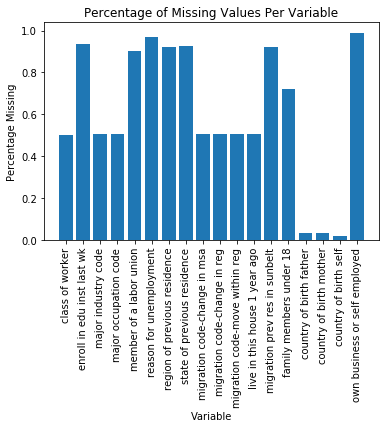

In [5]:
percent_miss = {} 
omit = []

for key,value in missing_values.items():
    percent_miss[key] = value / len(train_set)

for key, value in percent_miss.items(): 
    if value > .60: 
        omit.append(key)

columns = percent_miss.keys()
x_pos = np.arange(len(columns))
    
plt.bar(columns,percent_miss.values())
plt.xticks(x_pos,columns,rotation = 90)
plt.ylabel('Percentage Missing')
plt.xlabel('Variable')
plt.title('Percentage of Missing Values Per Variable')
plt.show()

The graph above displays the percentage of missing values for each variable. Below I actually decided to omit variables whose missing percentage is greater than 60%. Any features with missing percentage values higher than that cannot really add any value when trying to predict the target variable.

In [6]:
train_set = train_set.loc[:,~train_set.columns.isin(omit)]
test_set = test_set.loc[:,~test_set.columns.isin(omit)]

In order to properly visualize and analyze different variable distributions and relationships to the target variable (whether someone makes more or less than $50,000 per year), I felt it was important to recognize that both nominal/categorical and continuous variables were present in the dataset. I decided to start my analysis by creating a dataframe with only the continuous variables according to the metadata file.

In [7]:
continuous_feats = train_set.loc[:,['age','wage per hour','capital gains', 'capital losses', 'dividends from stocks', 'num persons worked for employer', 'weeks worked in year','year']] 

Below is simply a summary of minimum values, maximum values, and etc for the continuous variables. 

In [8]:
continuous_feats.loc[:,~continuous_feats.columns.isin(['year'])].describe()

,age,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,weeks worked in year
count,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,55.426908,434.71899,37.313788,197.529533,1.956180,94.499672
std,22.310895,274.896454,4697.53128,271.896428,1984.163658,2.365126,0.500001
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,94.000000
25%,15.000000,0.000000,0.00000,0.000000,0.000000,0.000000,94.000000
50%,33.000000,0.000000,0.00000,0.000000,0.000000,1.000000,94.000000
75%,50.000000,0.000000,0.00000,0.000000,0.000000,4.000000,95.000000
max,90.000000,9999.000000,99999.00000,4608.000000,99999.000000,6.000000,95.000000


With a dataframe of just continuous variables, I decided to plot density distributions of each variable. The variables were seperated out by their target variable outcome (whether the person made above or below $50,000 per year). The goal here was to visualize and find data points that could offer the most seperability between classes for each variable. For example, for the variable "age" directly below, it appears that age 20 is a decent point of sepearation between the two classes. 

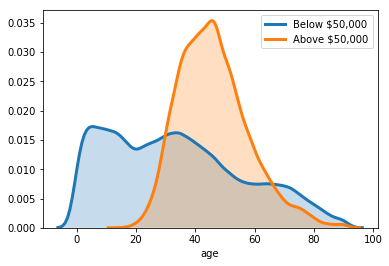

In [9]:
classification = ['Below $50,000', 'Above $50,000']
for i in range(0,2): 
    sns.distplot(continuous_feats['age'].loc[continuous_feats['year'] == i], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                label = classification[i])

Here are density plots for the other continuous variables seperated out by class. 

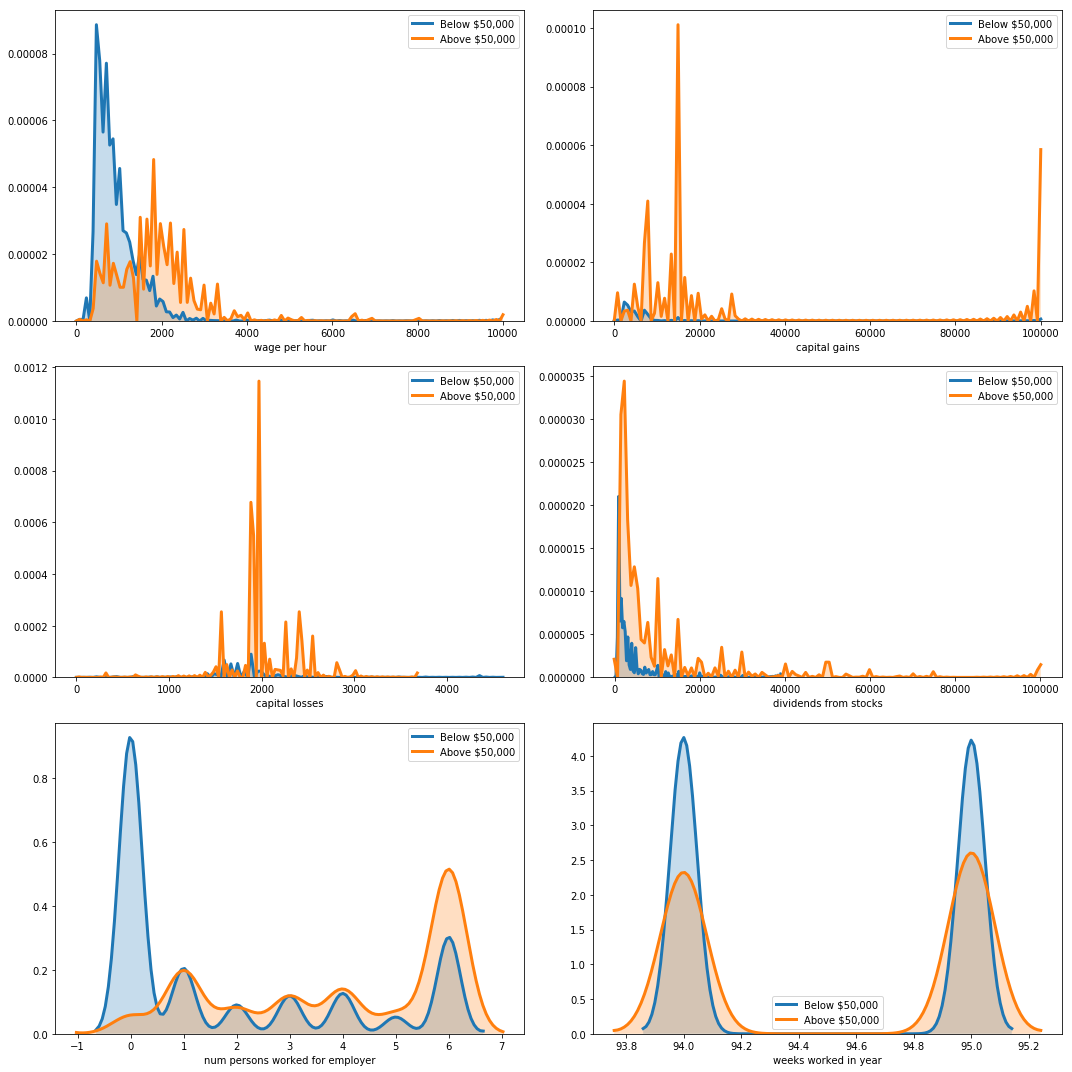

In [10]:
f, axes = plt.subplots(nrows= 3, ncols= 2,figsize=(15,15))
classification = ['Below $50,000', 'Above $50,000']

row = 0 
column = 0

for col in ['wage per hour','capital gains', 'capital losses', 'dividends from stocks', 'num persons worked for employer', 'weeks worked in year']:
    for i in range(0,2): 
        sns.distplot(continuous_feats[col].loc[continuous_feats['year'] == i], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 3}, label = classification[i],ax = axes[row,column])
    
    column += 1
    if column == 2:
        column = 0  
        row += 1 
        
plt.tight_layout()

Leveraging the insights provided by these visualizations, I chose points along each continuous variable that seemed to offer the most seperability between classes when creating bins to categorize these continuous variables below.

In [11]:
train_set['age - binned'] = pd.cut(continuous_feats['age'],[-1,20,continuous_feats['age'].max()], labels = ['min-20','20-max'],duplicates = 'drop')
train_set['wage per hour - binned'] = pd.cut(continuous_feats['wage per hour'],[-1,2000,continuous_feats['wage per hour'].max()],labels =['min-2000','2000-max'],duplicates = 'drop')
train_set['capital gains - binned'] = pd.cut(continuous_feats['capital gains'], [continuous_feats['capital gains'].min()-1,20000,continuous_feats['capital gains'].max()], labels = ['min-20000','20000-max'],duplicates = 'drop')
train_set['capital losses - binned'] = pd.cut(continuous_feats['capital losses'],[continuous_feats['capital losses'].min()-1,1000,2000,3000,continuous_feats['capital losses'].max()], labels = ['min-1000','1000-2000','2000- 3000','3000-max'],duplicates = 'drop')
train_set['dividends from stocks - binned'] = pd.cut(continuous_feats['dividends from stocks'],[continuous_feats['dividends from stocks'].min()-1,20000,continuous_feats['dividends from stocks'].max()], labels = ['min-20000', '20000-max'],duplicates = 'drop')
train_set['num persons worked for employer - binned'] = pd.cut(continuous_feats['num persons worked for employer'],[-1,0,continuous_feats['num persons worked for employer'].max()], labels = ['Zero','1-max'],duplicates = 'drop')
train_set['weeks worked in year - binned'] = pd.cut(continuous_feats['weeks worked in year'],[continuous_feats['weeks worked in year'].min()-1,94.5,continuous_feats['weeks worked in year'].max()], labels = ['min-94.5','max-94.5'], duplicates = 'drop')

In [12]:
#testing set is also binned so the schema is the equivalent for model testing
test_set['age - binned'] = pd.cut(continuous_feats['age'],[-1,20,continuous_feats['age'].max()], labels = ['min-20','20-max'],duplicates = 'drop')
test_set['wage per hour - binned'] = pd.cut(continuous_feats['wage per hour'],[-1,2000,continuous_feats['wage per hour'].max()],labels =['min-2000','2000-max'],duplicates = 'drop')
test_set['capital gains - binned'] = pd.cut(continuous_feats['capital gains'], [continuous_feats['capital gains'].min()-1,20000,continuous_feats['capital gains'].max()], labels = ['min-20000','20000-max'],duplicates = 'drop')
test_set['capital losses - binned'] = pd.cut(continuous_feats['capital losses'],[continuous_feats['capital losses'].min()-1,1000,2000,3000,continuous_feats['capital losses'].max()], labels = ['min-1000','1000-2000','2000- 3000','3000-max'],duplicates = 'drop')
test_set['dividends from stocks - binned'] = pd.cut(continuous_feats['dividends from stocks'],[continuous_feats['dividends from stocks'].min()-1,20000,continuous_feats['dividends from stocks'].max()], labels = ['min-20000', '20000-max'],duplicates = 'drop')
test_set['num persons worked for employer - binned'] = pd.cut(continuous_feats['num persons worked for employer'],[-1,0,continuous_feats['num persons worked for employer'].max()], labels = ['Zero','1-max'],duplicates = 'drop')
test_set['weeks worked in year - binned'] = pd.cut(continuous_feats['weeks worked in year'],[continuous_feats['weeks worked in year'].min()-1,94.5,continuous_feats['weeks worked in year'].max()], labels = ['min-94.5','max-94.5'], duplicates = 'drop')

These categorical/nominal features were created and added to the training set, because I wanted to make sure all variable comparison in terms of feature importance to the target variable were of the same standard. I chose a chi square contigency table to determine which features were most correlated with whether someone made above or below $50,000. I felt that this was an appropriate test to use, because it would give me an idea about what kind of impact feature values had on the target depending on how the data distribution compared to the data distribution if the variables values were totally independent of the target. 

In [13]:
#creating new dataframe without the original continuous features (binned versions are still included)
categorical_feats = train_set.loc[:,~train_set.columns.isin(['age','wage per hour','capital gains', 'capital losses', 'dividends from stocks', 'num personworked for employer', 'weeks worked in year','total personal income','year'])] 

In [14]:
p_values = {}

#for each variable/feature a contingency table is created
for col in categorical_feats.columns: 
    univariate_cnt = {}

    for i in train_set[col].unique(): 
        #each varable value is assigned its corresponding count for each class
        univariate_cnt[i] = (len(train_set[(train_set[col] == i) & (train_set['year'] == 1 )]), 
                              len(train_set[(train_set[col] == i) & (train_set['year'] == 0 )]))
    
    #empty table observations contingency table of the appropriate dimenstions is created 
    obs = np.zeros((2,len(train_set[col].unique())))

    value_num = 0 
    
    #contingency table for a feature/variable is created and populated with data distribution
    for key, value in univariate_cnt.items(): 
        obs[0,value_num] = value[0]
        obs[1,value_num] = value[1]
        value_num += 1 
        
    #p-value for each variable based on chi square contingency table (variable) is calculated and saved in the dictionary
    results = chi2_contingency(obs)
    p_values[col] = [results[1]]
    

In [15]:
#dataframe of p-value for features is created
p_val = pd.DataFrame.from_dict(p_values)
p_val = p_val.T.rename(index=str,columns={0:"p-value"})
p_val.sort_values("p-value", inplace=True)

In [16]:
p_val

,p-value
class of worker,0.000000e+00
age - binned,0.000000e+00
veterans benefits,0.000000e+00
fill inc questionnaire for veteran's admin,0.000000e+00
num persons worked for employer,0.000000e+00
capital losses - binned,0.000000e+00
dividends from stocks - binned,0.000000e+00
num persons worked for employer - binned,0.000000e+00
detailed household and family stat,0.000000e+00
tax filer stat,0.000000e+00


In [17]:
feats = list(p_val.loc[p_val['p-value'] == 0].index)

All of the features actually had p-values lower than standard levels of significance such as .01. So in order to choose the lowest amongst the low, I chose those variables whose p-value was equal to 0. A low p-value indicates statistical significance and strong feature correlation to the target, so these variables with values equal to zero could be the ones most closely correlated to the target variable.

In [18]:
feats

['class of worker',
 'age - binned',
 'veterans benefits',
 "fill inc questionnaire for veteran's admin",
 'num persons worked for employer',
 'capital losses - binned',
 'dividends from stocks - binned',
 'num persons worked for employer - binned',
 'detailed household and family stat',
 'tax filer stat',
 'detailed household summary in household',
 'sex',
 'detailed industry recode',
 'detailed occupation recode',
 'education',
 'full or part time employment stat',
 'marital stat',
 'capital gains - binned',
 'major occupation code',
 'major industry code']

In [19]:
cat_feats_examples = [
 'num persons worked for employer',
 'detailed household summary in household',
 'tax filer stat',
 'full or part time employment stat',
 'sex']

Below plots visualizations for some of the original categorical variables that seem to be most important according to the chi square test. 

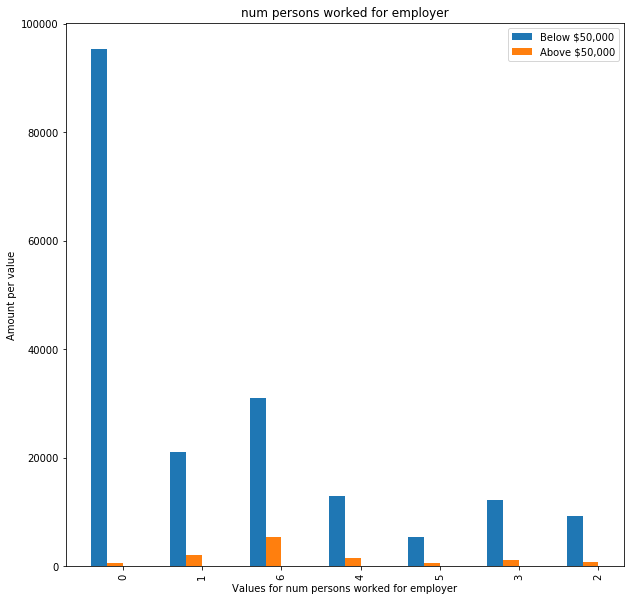

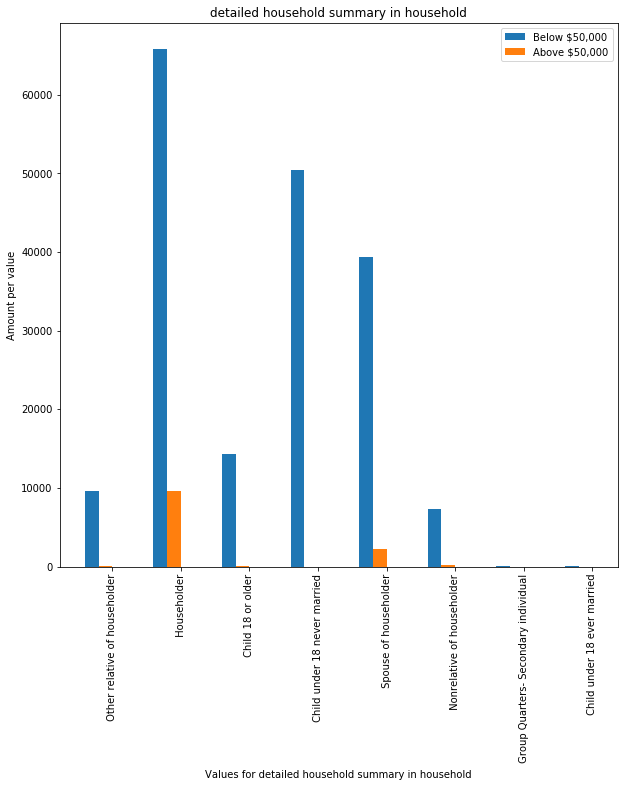

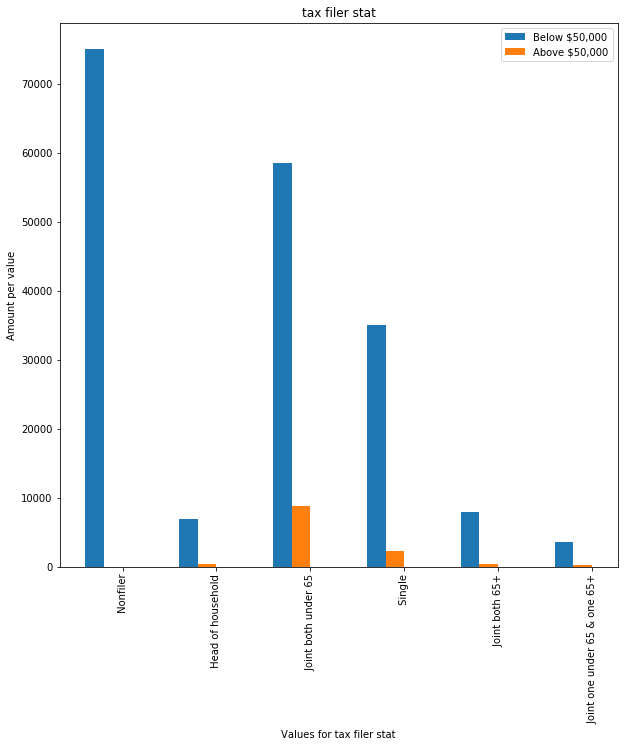

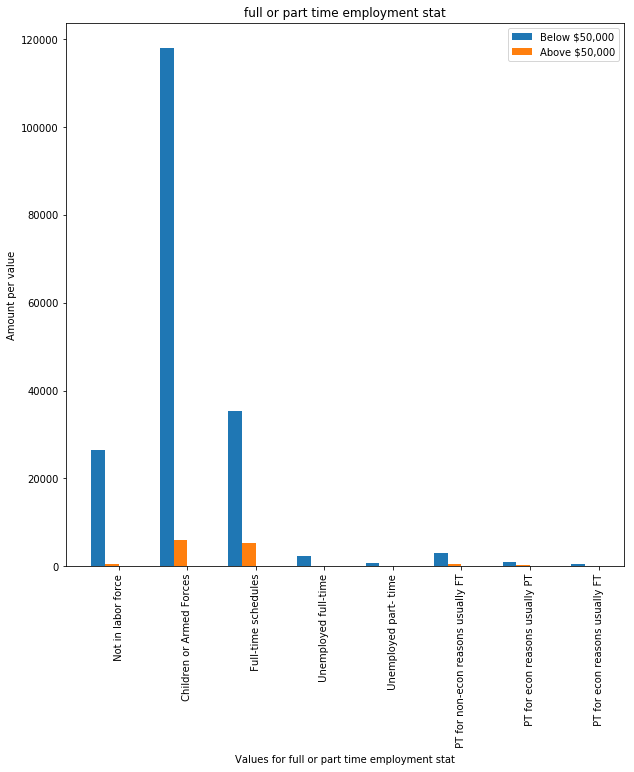

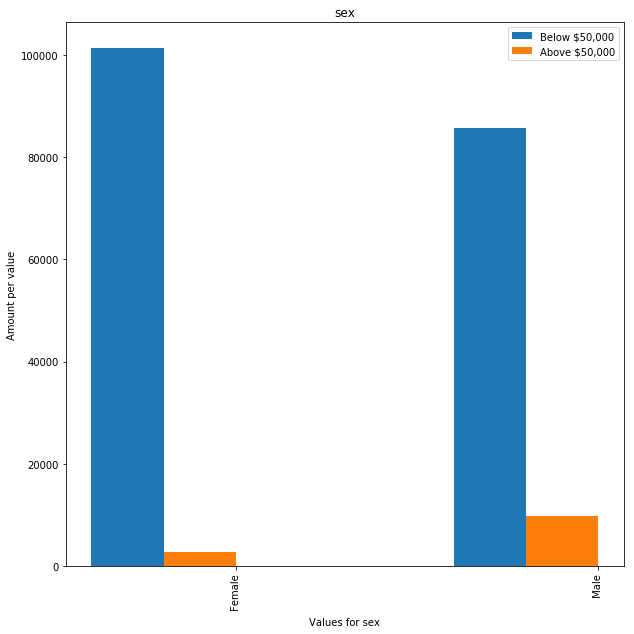

In [20]:
%matplotlib inline

for col in cat_feats_examples:
    
    fig, ax = plt.subplots()
    ind = np.arange(len(list(train_set[col].unique())))    # the x locations for the groups
    width = 0.20        # the width of the bars
    
    above50 = []
    below50 = []
    
    for i in train_set[col].unique(): 
        above50.append(len(train_set[(train_set[col] == i) & (train_set['year'] == 1 )]))
        below50.append(len(train_set[(train_set[col] == i) & (train_set['year'] == 0 )]))

    p1 = ax.bar(.10 + ind, below50, width)
    p2 = ax.bar(.10 + ind + width,above50, width)
    
    ax.set_title(col)
    plt.xlabel('Values for '+ col)
    plt.ylabel('Amount per value')
    ax.set_xticks(ind + width + width)
    ax.set_xticklabels(train_set[col].unique())
    ax.legend((p1[0],p2[0]),('Below $50,000','Above $50,000'))
    ax.yaxis.set_units(1)
    ax.autoscale_view()
    plt.xticks(rotation=90)
    fig = plt.gcf()
    fig.set_size_inches(10,10)
    plt.show()


Some general insights about people who make above $50,000 per year from some of the original categorical variables include: the person is more likely to be male, the person is more likely to be employed full time, and more likely to be a householder or spouse of a householder. 

# Model Testing

To verify whether the features I identified really had a stronger correlation to the target than other variables in the dataset, I decided to build two decision tree classifier models. The first model is a baseline model trained using all of the features in the dataset (excluding those with high percentage of values missing). The second model is trained using only those variables that I thought were most important based upon my chi square analysis. By comparing the performance of the two models, I would recieve insights into whether the variables/features I chose had a stronger correlation with whether someone makes more or less than $50,000. 

Note: When creating both decision tree models I decided to use entropy over the gini index as it is the more stringent of the two when it comes to measuring node purity. 

![Node Impurity Measure](./Node_Purity_Measure.png)

In [21]:
#removing original continuous variables since they are being replaced by the categorical binned versions
train_set = train_set.loc[:,~train_set.columns.isin(['age','wage per hour','capital gains', 'capital losses', 'dividends from stocks', 'num personworked for employer', 'weeks worked in year','total personal income'])] 
test_set = test_set.loc[:,~test_set.columns.isin(['age','wage per hour','capital gains', 'capital losses', 'dividends from stocks', 'num personworked for employer', 'weeks worked in year','total personal income'])] 

Part 1: The first model is built using all the features in the original dataset.

In [22]:
#decision tree classifier is initialized
clf = DecisionTreeClassifier(criterion = 'entropy')

#the target variable is saved seperately 
target = train_set['year'].values

#new training dataframe is created with the target dropped 
newtrain_set = train_set.loc[:,~train_set.columns.isin(['year'])] 

In [23]:
#label encoder is applied for the categorical values for each variable
newtrain_set = newtrain_set.apply(preprocessing.LabelEncoder().fit_transform)

#the model is then fitted using the training set
clf.fit(newtrain_set,target)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [24]:
#the target variable is dropped from the test set
newtest_set = test_set.drop('year', 1)

#label encoder is applied for the categorical values for each variable in the test set
newtest_set = newtest_set.apply(preprocessing.LabelEncoder().fit_transform)

#performance score is calculated on the test set
testScore = clf.score(newtest_set,test_set['year'].values)

print('Testing Accuracy: ', testScore)

Testing Accuracy:  0.9256029349852649


Part 2: The second model is built using only those features I deemed most important from my chi square analysis. 

In [25]:
#the target is saved seperately 
target = train_set['year'].values

#a training set with only the best features is created
best_feats_train = train_set.loc[:,feats] 

#label encoder is applied for the categorical values for each variable in the train set
best_feats_train = best_feats_train.apply(preprocessing.LabelEncoder().fit_transform)

#the model is then fitted using the training set with only the best features
clf.fit(best_feats_train,target)


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [26]:
#target is saved seperately 
target = test_set['year'].values

#a test set with only the best features is created
best_feats_test = test_set.loc[:,feats] 

#label encoder is applied for the categorical values for each variable in the test set
best_feats_test = best_feats_test.apply(preprocessing.LabelEncoder().fit_transform)

#performance score is calculated on the test set
testScore = clf.score(best_feats_test,target)
print('Testing Accuracy: ', testScore)

Testing Accuracy:  0.9284296625969808


As you can see, my second model built using only those features I deemed most important slightly improved over my baseline model which includes all of the features. My baseline model has a test score accuracy of about 92.56% while my second model has a test score accuracy of about 92.84%. 

# Conclusion 

The following features seem to have a heavier correlation with whether someone makes more or less than $50,000 than the others:  

In [27]:
feats

['class of worker',
 'age - binned',
 'veterans benefits',
 "fill inc questionnaire for veteran's admin",
 'num persons worked for employer',
 'capital losses - binned',
 'dividends from stocks - binned',
 'num persons worked for employer - binned',
 'detailed household and family stat',
 'tax filer stat',
 'detailed household summary in household',
 'sex',
 'detailed industry recode',
 'detailed occupation recode',
 'education',
 'full or part time employment stat',
 'marital stat',
 'capital gains - binned',
 'major occupation code',
 'major industry code']

Challenges: I would say the biggest challenge I experienced was understanding why there were p-values equal to zero.I find it to be a bit suspicious that this is the case. However, I did try to double check and analyze my chi square analysis calculations. I made sure all of my observations were more than 1 dimenisional and made sure that the observed and expected frequency in each cell was at least 5, as these factors would invalidate my calculations according to the chi square documentation. I believe future work on this assignment could possibly include performing other tests that could indicate feature importance and see how similar the most important feaures generated from that are to the ones from my chi square analysis. 